In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle

In [ ]:
def load_batch(f):
  with open(f,'rb') as fl:
    d=pickle.load(fl,encoding='bytes')
  return d[b'data'], np.array(d[b'labels'])


In [ ]:
train_data=[]
train_label=[]
for i in range(1,6):
  d, l=load_batch(f'data_batch_{i}')
  train_data.append(d)
  train_label.append(l)

In [ ]:
x_train=np.concatenate(train_data)
y_train=np.concatenate(train_label)

In [ ]:
x_train.shape

(50000, 3072)

In [ ]:
y_train.shape

(50000,)

In [ ]:
x_test, y_test=load_batch('test_batch')

In [ ]:
x_test.shape

(10000, 3072)

In [ ]:
y_test.shape

(10000,)

In [ ]:
classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

DataFrame Head:
   class_name  label
0        frog      6
1       truck      9
2       truck      9
3        deer      4
4  automobile      1


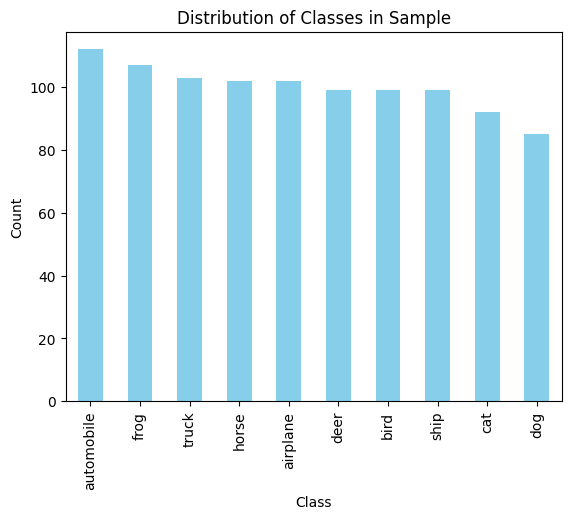

In [ ]:
# Create a sample DataFrame to visualize the structure
df = pd.DataFrame(x_train[:1000]) # First 1000 images
df['label'] = y_train[:1000]
df['class_name'] = df['label'].apply(lambda x: classes[x])

print("DataFrame Head:")
print(df[['class_name', 'label']].head())

# Visualize class distribution
df['class_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Classes in Sample")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,label,class_name
0,59,43,50,68,98,119,139,145,149,149,...,65,59,46,57,104,140,84,72,6,frog
1,154,126,105,102,125,155,172,180,142,111,...,67,101,122,133,136,139,142,144,9,truck
2,255,253,253,253,253,253,253,253,253,253,...,80,69,66,72,79,83,83,84,9,truck
3,28,37,38,42,44,40,40,24,32,43,...,59,42,44,48,38,28,37,46,4,deer
4,170,168,177,183,181,177,181,184,189,189,...,85,82,83,79,78,82,78,80,1,automobile


##KNN from Scratch and and going for suitable K

In [ ]:
class KNN:
    def __init__(self, k=3, dist_metric='l2', p=2):
        self.k = k
        self.dist_metric = dist_metric
        self.p = p # Store p for Minkowski distance

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        num_test = X_test.shape[0]
        preds = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            if self.dist_metric == 'l1':
                # L1 Distance (Manhattan)
                dists = np.sum(np.abs(self.X_train - X_test[i, :]), axis=1)
            elif self.dist_metric == 'l2':
                # L2 Distance (Euclidean) - Vectorized: (A-B)^2 = A^2 + B^2 - 2AB
                dists = np.sqrt(np.sum(self.X_train**2, axis=1) +
                                np.sum(X_test[i, :]**2) -
                                2 * self.X_train.dot(X_test[i, :]))
            elif self.dist_metric == 'minkowski':
                # Minkowski distance
                dists = np.power(np.sum(np.power(np.abs(self.X_train - X_test[i, :]), self.p), axis=1), 1/self.p)
            else:
                raise ValueError("Unsupported distance metric")

            # Find indices of k nearest neighbors
            k_indices = np.argsort(dists)[:self.k]
            k_labels = self.y_train[k_indices]
            preds[i] = np.argmax(np.bincount(k_labels))

        return preds

In [ ]:
num_training = int(0.8 * x_train.shape[0])
mask = range(num_training)
x_train_split = x_train[mask]
y_train_split = y_train[mask]

mask_val = range(num_training, x_train.shape[0])
x_val = x_train[mask_val]
y_val = y_train[mask_val]

In [ ]:
k_values = [3, 5, 7, 10, 12, 14]
# Define metrics and their specific parameters (e.g., 'p' for Minkowski)
metric_configs = [
    {'name': 'l1'},
    {'name': 'l2'},
    {'name': 'minkowski', 'p': 3} # Example Minkowski with p=3
]
results = {config['name']: [] for config in metric_configs}

x_val_subset = x_val[:1000]
y_val_subset = y_val[:1000]

for config in metric_configs:
    metric_name = config['name']
    p_value = config.get('p') # Get p if available, None otherwise

    if metric_name == 'minkowski':
        print(f"Evaluating {metric_name.upper()} distance with p={p_value}...")
    else:
        print(f"Evaluating {metric_name.upper()} distance...")

    for k in k_values:
        if metric_name == 'minkowski':
            knn = KNN(k=k, dist_metric=metric_name, p=p_value)
        else:
            knn = KNN(k=k, dist_metric=metric_name) # p is not used by l1/l2 here, it will default

        knn.train(x_train_split, y_train_split)
        y_pred = knn.predict(x_val_subset)
        error = np.mean(y_pred != y_val_subset)
        results[metric_name].append(error)
        print(f"  k={k}, error={error:.4f}")

Evaluating L1 distance...
  k=3, error=0.7770
  k=5, error=0.7630
  k=7, error=0.7520
  k=10, error=0.7510
  k=12, error=0.7450
  k=14, error=0.7360
Evaluating L2 distance...
  k=3, error=0.8960
  k=5, error=0.8960
  k=7, error=0.8960
  k=10, error=0.8960
  k=12, error=0.8960
  k=14, error=0.8960
Evaluating MINKOWSKI distance with p=3...
  k=3, error=0.8640
  k=5, error=0.8450
  k=7, error=0.8380
  k=10, error=0.8420
  k=12, error=0.8470
  k=14, error=0.8490


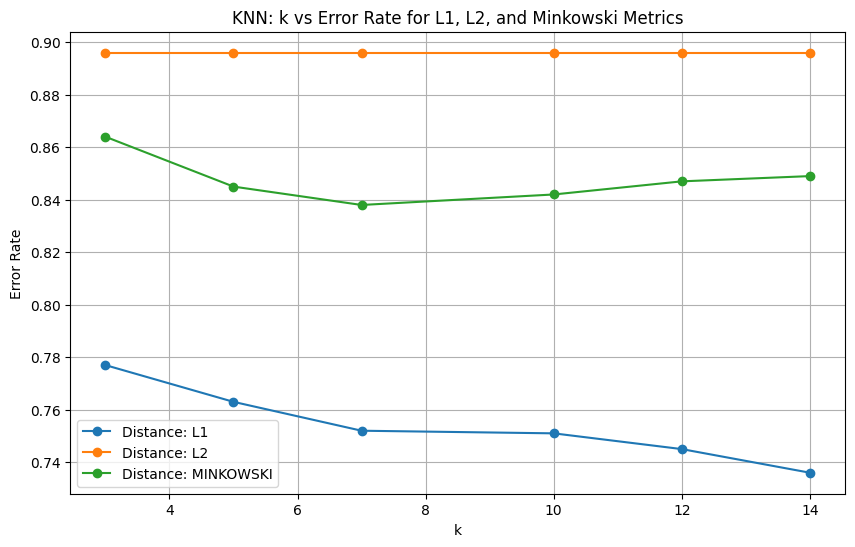

In [ ]:
plt.figure(figsize=(10, 6))
# Iterate over the keys of the results dictionary to plot all metrics
for m_name in results.keys():
    plt.plot(k_values, results[m_name], marker='o', label=f'Distance: {m_name.upper()}')

plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('KNN: k vs Error Rate for L1, L2, and Minkowski Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
overall_best_error = float('inf')
overall_best_k = None
overall_best_metric_name = None
overall_best_p = None # To store p for Minkowski if it's the best

for config in metric_configs:
    m_name = config['name']
    current_results = results[m_name]
    best_k_for_metric_idx = np.argmin(current_results)
    best_error_for_metric = current_results[best_k_for_metric_idx]
    best_k_for_metric_value = k_values[best_k_for_metric_idx]

    # Print best k for each metric
    metric_display_name = m_name.upper()
    if m_name == 'minkowski':
        metric_display_name += f" (p={config.get('p')})"
    print(f"Best k for {metric_display_name}: {best_k_for_metric_value} (Error: {best_error_for_metric:.4f})")

    # Check for overall best
    if best_error_for_metric < overall_best_error:
        overall_best_error = best_error_for_metric
        overall_best_k = best_k_for_metric_value
        overall_best_metric_name = m_name
        overall_best_p = config.get('p') # Store p if it's minkowski, else None

print(f"\nOverall Best K: {overall_best_k}")
print(f"Overall Best Metric: {overall_best_metric_name.upper()}")
if overall_best_metric_name == 'minkowski':
    print(f"Minkowski p: {overall_best_p}")
print(f"Overall Lowest Error: {overall_best_error:.4f}")

Best k for L1: 14 (Error: 0.7360)
Best k for L2: 3 (Error: 0.8960)
Best k for MINKOWSKI (p=3): 7 (Error: 0.8380)

Overall Best K: 14
Overall Best Metric: L1
Overall Lowest Error: 0.7360


Final Test Accuracy: 25.01%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.21      0.69      0.32      1000
  automobile       0.41      0.10      0.16      1000
        bird       0.20      0.37      0.26      1000
         cat       0.24      0.13      0.17      1000
        deer       0.21      0.24      0.22      1000
         dog       0.29      0.20      0.23      1000
        frog       0.37      0.10      0.16      1000
       horse       0.46      0.08      0.14      1000
        ship       0.32      0.54      0.40      1000
       truck       0.57      0.05      0.09      1000

    accuracy                           0.25     10000
   macro avg       0.33      0.25      0.22     10000
weighted avg       0.33      0.25      0.22     10000



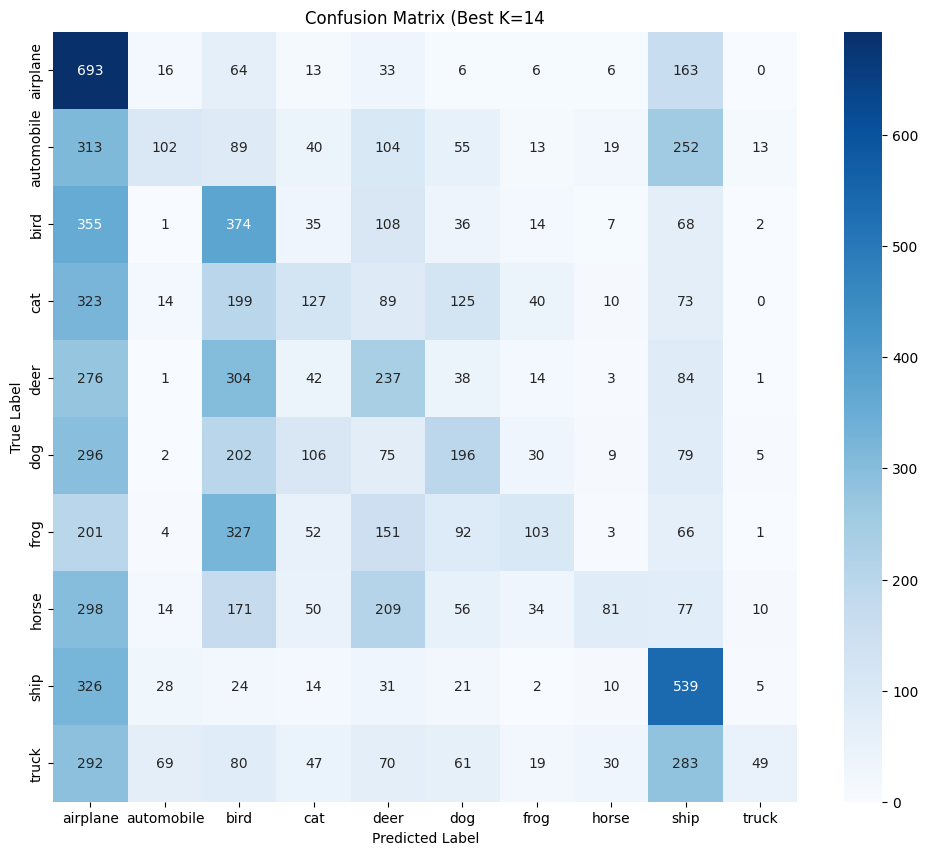

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Train on the full training set (50,000 samples) using the overall best parameters
if overall_best_metric_name == 'minkowski':
    final_model = KNN(k=overall_best_k, dist_metric=overall_best_metric_name, p=overall_best_p)
else:
    final_model = KNN(k=overall_best_k, dist_metric=overall_best_metric_name)

final_model.train(x_train, y_train)

# 2. Predict the test batch (10,000 samples)
# Note: This might take a few minutes due to the dataset size
y_test_pred = final_model.predict(x_test)

# 3. Calculate Accuracy Score
accuracy = np.mean(y_test_pred == y_test)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

# 4. Detailed Scores (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=classes))

# 5. Confusion Matrix Visualization

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title(f'Confusion Matrix (Best K={overall_best_k}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()